# Preprocess data

In [2]:
import cudf
from cuml.preprocessing import LabelEncoder
import pandas as pd
from sklearn.preprocessing import QuantileTransformer
from cuml.neighbors import KNeighborsClassifier
from cuml.model_selection import train_test_split
from cuml.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from cuml.svm import SVC
from cuml import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import cupy as cp
from cuml.ensemble import RandomForestClassifier
from cuml.model_selection import GridSearchCV
import sklearn.ensemble 
import xgboost
import shap
from sklearn.model_selection import cross_val_score
import cuml
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import VotingClassifier
from cuml import ForestInference
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier

import warnings

warnings.filterwarnings("ignore")

In [3]:
df = cudf.read_csv('Dataset4.csv')
display(df.head())
display(df.info())

,id.orig_p,id.resp_p,proto,service,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,target
0,38667.0,1883.0,tcp,mqtt,32.011598,9.0,5.0,3.0,3.0,0.281148,...,0.0,29729182.96,29729182.96,29729182.96,29729182.96,0.0,64240.0,26847.0,502.0,MQTT_Publish
1,51143.0,1883.0,tcp,mqtt,31.883584,9.0,5.0,3.0,3.0,0.282277,...,0.0,29855277.06,29855277.06,29855277.06,29855277.06,0.0,64240.0,26847.0,502.0,MQTT_Publish
2,44761.0,1883.0,tcp,mqtt,32.124053,9.0,5.0,3.0,3.0,0.280164,...,0.0,29842149.02,29842149.02,29842149.02,29842149.02,0.0,64240.0,26847.0,502.0,MQTT_Publish
3,60893.0,1883.0,tcp,mqtt,31.961063,9.0,5.0,3.0,3.0,0.281593,...,0.0,29913774.97,29913774.97,29913774.97,29913774.97,0.0,64240.0,26847.0,502.0,MQTT_Publish
4,51087.0,1883.0,tcp,mqtt,31.902362,9.0,5.0,3.0,3.0,0.282111,...,0.0,29814704.90,29814704.90,29814704.90,29814704.90,0.0,64240.0,26847.0,502.0,MQTT_Publish


<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 123117 entries, 0 to 123116
Data columns (total 84 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   id.orig_p                 123115 non-null  float64
 1   id.resp_p                 123111 non-null  float64
 2   proto                     123110 non-null  object
 3   service                   123115 non-null  object
 4   flow_duration             123114 non-null  float64
 5   fwd_pkts_tot              123109 non-null  float64
 6   bwd_pkts_tot              123112 non-null  float64
 7   fwd_data_pkts_tot         123112 non-null  float64
 8   bwd_data_pkts_tot         123113 non-null  float64
 9   fwd_pkts_per_sec          123115 non-null  float64
 10  bwd_pkts_per_sec          123116 non-null  float64
 11  flow_pkts_per_sec         123114 non-null  float64
 12  down_up_ratio             123114 non-null  float64
 13  fwd_header_size_tot       123114 non-null  float

None

## Remove NAN rows

In [4]:
# df[df.isna().any(axis=1)]
df.dropna(inplace=True)
df.shape

(122818, 84)

There seems to be 3 object dtype which are proto, service and target

In [5]:
df['proto'].value_counts(), df['service'].value_counts(), df['target'].value_counts()

(proto
 tcp     110157
 udp      12604
 icmp        57
 Name: count, dtype: int64,
 service
 -         102617
 dns         9732
 mqtt        4119
 http        3453
 ssl         2654
 ntp          120
 dhcp          50
 irc           43
 ssh           28
 radius         2
 Name: count, dtype: int64,
 target
 DOS_SYN_Hping                 94434
 Thing_Speak                    8085
 ARP_poisioning                 7729
 MQTT_Publish                   4133
 NMAP_UDP_SCAN                  2584
 NMAP_XMAS_TREE_SCAN            2007
 NMAP_OS_DETECTION              1994
 NMAP_TCP_scan                  1001
 DDOS_Slowloris                  533
 Wipro_bulb                      253
 Metasploit_Brute_Force_SSH       37
 NMAP_FIN_SCAN                    28
 Name: count, dtype: int64)

## Label Encode

In [6]:
# Columns to remove
categorical_columns = ['proto', 'service', 'target']

# Initialize OneHotEncoder
le = LabelEncoder()

# Label encode those columns
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

df.head()

,id.orig_p,id.resp_p,proto,service,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,target
0,38667.0,1883.0,1,5,32.011598,9.0,5.0,3.0,3.0,0.281148,...,0.0,29729182.96,29729182.96,29729182.96,29729182.96,0.0,64240.0,26847.0,502.0,3
2,44761.0,1883.0,1,5,32.124053,9.0,5.0,3.0,3.0,0.280164,...,0.0,29842149.02,29842149.02,29842149.02,29842149.02,0.0,64240.0,26847.0,502.0,3
3,60893.0,1883.0,1,5,31.961063,9.0,5.0,3.0,3.0,0.281593,...,0.0,29913774.97,29913774.97,29913774.97,29913774.97,0.0,64240.0,26847.0,502.0,3
4,51087.0,1883.0,1,5,31.902362,9.0,5.0,3.0,3.0,0.282111,...,0.0,29814704.90,29814704.90,29814704.90,29814704.90,0.0,64240.0,26847.0,502.0,3
5,48579.0,1883.0,1,5,31.869686,9.0,5.0,3.0,3.0,0.282400,...,0.0,29825548.17,29825548.17,29825548.17,29825548.17,0.0,64240.0,26847.0,502.0,3


In [7]:
df = df.round(4) # round numerical columns to 4 decimal
X = df.drop('target', axis=1)
y = df.target
X = X.to_pandas()
y = y.to_pandas()

## Oversample

In [8]:
# # Apply oversampling
# ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
# X_resampled, y_resampled = ros.fit_resample(X, y)

# # Convert resampled data back into a pandas DataFrame
# X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
# y_resampled = pd.DataFrame(y_resampled, columns=['target'])

In [9]:
# y_resampled.value_counts()

## Feature scaling

Identify the categorical columns before features scaling coz scaling only works on continuous data.

In [10]:
# Check the unique value of each feature
unique_values = X.nunique()
categorical_columns = unique_values[unique_values < 10].index.tolist()
print("Categorical columns based on unique values:", categorical_columns)

Categorical columns based on unique values: ['proto', 'fwd_header_size_min', 'fwd_header_size_max', 'bwd_header_size_min', 'bwd_header_size_max', 'flow_SYN_flag_count', 'flow_RST_flag_count', 'fwd_URG_flag_count', 'bwd_URG_flag_count', 'flow_CWR_flag_count', 'flow_ECE_flag_count']


In [11]:
# Separate numerical columns (excluding the specified columns)
numerical_columns = [col for col in X.columns if col not in categorical_columns]

# Apply Quantile Transformer only to the numerical columns
qt = QuantileTransformer(output_distribution='normal', random_state=42)
X_transformed = qt.fit_transform(X[numerical_columns])

# Convert the transformed numerical data back to a DataFrame
X_numerical_transformed_df = pd.DataFrame(X_transformed, columns=numerical_columns)

# Convert the transformed numerical data back to a DataFrame
X_transformed_df = pd.concat([X[categorical_columns].reset_index(drop=True), 
                                X_numerical_transformed_df.reset_index(drop=True)], axis=1)
X_transformed_df.head()

,proto,fwd_header_size_min,fwd_header_size_max,bwd_header_size_min,bwd_header_size_max,flow_SYN_flag_count,flow_RST_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,...,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
0,1,32.0,40.0,32.0,40.0,2.0,1.0,0.0,0.0,0,...,2.103430,-5.199338,1.920839,1.906524,1.865430,1.910208,-5.199338,1.644369,1.644369,1.513589
1,1,32.0,40.0,32.0,40.0,2.0,1.0,0.0,0.0,0,...,2.101537,-5.199338,1.941298,1.932645,1.888954,1.936746,-5.199338,1.644369,1.644369,1.513589
2,1,32.0,40.0,32.0,40.0,2.0,1.0,0.0,0.0,0,...,1.757899,-5.199338,1.960327,1.959561,1.910732,1.959708,-5.199338,1.644369,1.644369,1.513589
3,1,32.0,40.0,32.0,40.0,2.0,1.0,0.0,0.0,0,...,1.861746,-5.199338,1.935628,1.924817,1.883244,1.930849,-5.199338,1.644369,1.644369,1.513589
4,1,32.0,40.0,32.0,40.0,2.0,1.0,0.0,0.0,0,...,1.752205,-5.199338,1.937861,1.927873,1.885493,1.933171,-5.199338,1.644369,1.644369,1.513589


# 1. Differences between hyperparameter and parameter in ML
Hyperparameters are settings we tweak like learning rate (gradient-based model), Regularization, number of trees (tree models), layers (NN). These values are set before we train our model. Parameters are the final output like the slope and intercept line of linear regression or weights and biases in Neural Networks.

I will use KNN and SVM as examples

## KNN
KNN doesn’t have parameters since it works by determining the class labels by its nearest k. It does have hyperparameters like `n_neighbors`: number of neighbors to query; `algorithm`: the query algorithm; `metric`: distance metric to use.

In [12]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_transformed_df, y, train_size=0.8, random_state=5)
X_train.shape, X_test.shape

((98254, 83), (24564, 83))

In [13]:
y_train.value_counts()

target
2     75677
10     6436
0      6163
3      3272
8      2043
6      1598
9      1592
7       794
1       426
11      207
4        27
5        19
Name: count, dtype: int64

In [14]:
# X_train = X_train.to_numpy()
# X_test = X_test.to_numpy()
y_train = y_train.to_numpy().ravel()
# y_test = y_test.to_numpy()

In [14]:
# Fit knn model
knn = KNeighborsClassifier(n_neighbors=10, algorithm='brute', metric='euclidean')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Accuracy: {accuracy:.5f}")

KNN Accuracy: 0.99548


## SVM
The parameters are weights (coefficients), and bias (intercept) learned during model training to define the decision boundary. Hyperparameters `C`: Regularization; `kernel`: kernel type; `gamma`: kernel coefficient.

In [15]:
# Fit svm model
svm_model = SVC(C=1.0, kernel='rbf', gamma='scale')
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {accuracy:.5f}")

[W] [09:36:50.036310] Warning: could not fill working set, found only 938 elements
[W] [09:36:50.040427] Warning: could not fill working set, found only 775 elements
[W] [09:36:50.046592] Warning: could not fill working set, found only 937 elements
[W] [09:36:50.048492] Warning: could not fill working set, found only 1019 elements
[W] [09:36:50.098324] Warning: could not fill working set, found only 938 elements
[W] [09:36:50.101959] Warning: could not fill working set, found only 798 elements
[W] [09:36:50.106763] Warning: could not fill working set, found only 929 elements
[W] [09:36:50.111085] Warning: could not fill working set, found only 931 elements
[W] [09:36:50.243359] Warning: could not fill working set, found only 938 elements
[W] [09:36:50.246509] Warning: could not fill working set, found only 772 elements
[W] [09:36:50.250073] Warning: could not fill working set, found only 933 elements
[W] [09:36:50.289795] Warning: could not fill working set, found only 938 elements
[W]

# 2. Prove that Elastic net can be used as either LASSO or Ridge regulariser
Elastic net is a combination of both LASSO and Ridge, and why can tune it to behave like either of the two or as a mix.
- Elastic net with `l1_ratio=1.0` behaves like LASSO (`L1` regularization)
- Elastic net with `l1_ratio=0.0` behaves like Ridge (`L2` regularization)
- Elastic net with `l1_ratio=0.5` is the combination of both

In [16]:
# L1 using Elastic and LASSO

lasso = LogisticRegression(penalty='l1', max_iter=1000)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"LASSO Accuracy: {accuracy:.5f}")

elastic = LogisticRegression(penalty='elasticnet', l1_ratio=1.0, max_iter=1000)
elastic.fit(X_train, y_train)
y_pred = elastic.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Elastic Accuracy: {accuracy:.5f}")

[W] [09:36:59.849448] QWL-QN: max iterations reached
[W] [09:36:59.849834] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
LASSO Accuracy: 0.99414
[W] [09:37:05.041008] QWL-QN: max iterations reached
[W] [09:37:05.041577] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
Elastic Accuracy: 0.99402


In [17]:
# L2 using Elastic and Ridge

ridge = LogisticRegression(penalty='l2', max_iter=1000)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"LASSO Accuracy: {accuracy:.5f}")

elastic = LogisticRegression(penalty='elasticnet', l1_ratio=0.0, max_iter=1000)
elastic.fit(X_train, y_train)
y_pred = elastic.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Elastic Accuracy: {accuracy:.5f}")

[W] [09:37:09.945344] L-BFGS: max iterations reached
[W] [09:37:09.945820] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
LASSO Accuracy: 0.99430
[W] [09:37:14.780595] L-BFGS: max iterations reached
[W] [09:37:14.781290] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
Elastic Accuracy: 0.99426


We can see that the accuracy for both L1 using LASSO, and Elastic tune to be LASSO is the same. The same can be said for Ridge, and Elastic tune to be Ridge. 

# 3. Feature importance

## Random forest feature importance
I have used the power of Random Forest model to show me the feature importance of the columns. Géron (2019) said that Random Forest looks at how much the tree nodes used a particular feature to reduce the impurity on average across all trees in the forest. 

In [86]:
rf_model = sklearn.ensemble.RandomForestClassifier(n_estimators=500, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=42)

In [87]:
important_features = []
total_score = 0

for score, name in zip(rf_model.feature_importances_, X.columns):
    if score > 0.01: 
        print(f"{round(score, 2)} - {name}")
        important_features.append(name)
        total_score += score
        
print("Important features:", important_features)
print("Total score of important features:", round(total_score, 2))

0.01 - fwd_data_pkts_tot
0.01 - flow_pkts_per_sec
0.09 - down_up_ratio
0.04 - fwd_header_size_tot
0.01 - fwd_header_size_min
0.01 - fwd_header_size_max
0.01 - bwd_header_size_min
0.01 - bwd_PSH_flag_count
0.01 - fwd_URG_flag_count
0.02 - bwd_URG_flag_count
0.06 - fwd_pkts_payload.min
0.04 - fwd_pkts_payload.max
0.04 - fwd_pkts_payload.tot
0.08 - fwd_pkts_payload.avg
0.01 - bwd_pkts_payload.max
0.01 - bwd_pkts_payload.tot
0.01 - bwd_pkts_payload.avg
0.02 - flow_pkts_payload.max
0.02 - flow_pkts_payload.tot
0.02 - flow_pkts_payload.avg
0.02 - fwd_iat.min
0.01 - fwd_iat.max
0.01 - fwd_iat.tot
0.01 - fwd_iat.avg
0.03 - flow_iat.min
0.02 - flow_iat.max
0.03 - flow_iat.tot
0.02 - flow_iat.avg
0.05 - fwd_subflow_bytes
0.02 - active.min
0.02 - active.max
0.02 - active.tot
0.02 - active.avg
0.01 - fwd_init_window_size
0.01 - fwd_last_window_size
Important features: ['fwd_data_pkts_tot', 'flow_pkts_per_sec', 'down_up_ratio', 'fwd_header_size_tot', 'fwd_header_size_min', 'fwd_header_size_max', 'b

## XGBoost and SHAP

In [15]:
model = xgboost.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [16]:
explainer = shap.explainers.GPUTree(model, X_test.to_numpy())
shap_values = explainer(X_test.to_numpy())
shap_values = shap_values

This is the mean absolute value of each feature over all the instances. I will use this plot below to determine feature importance.

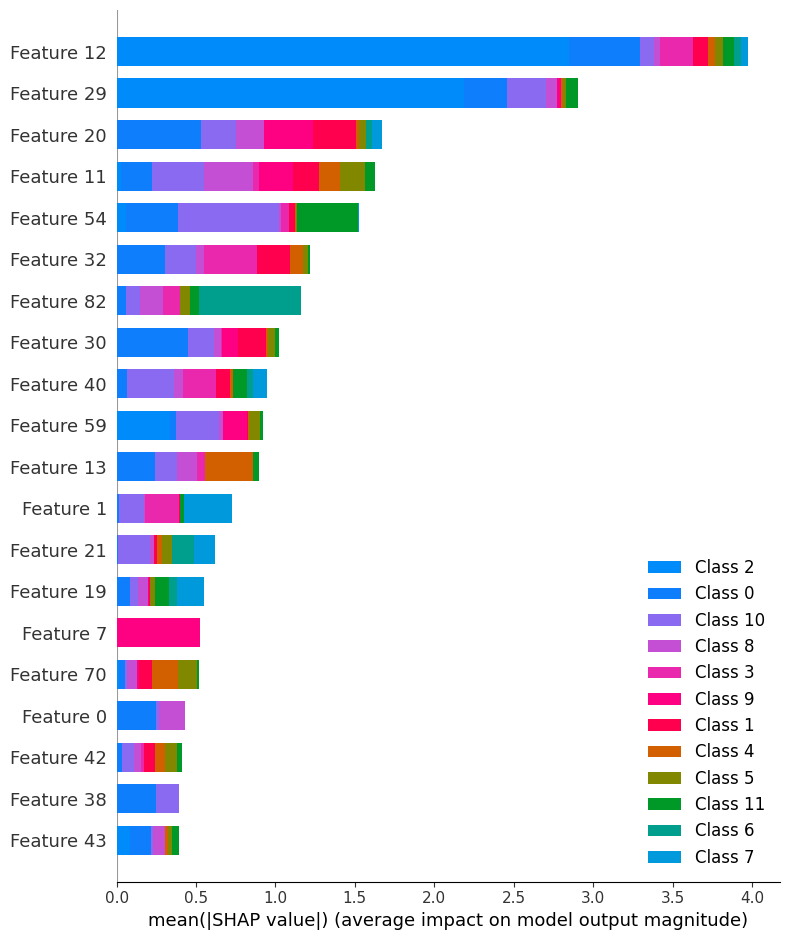

In [17]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

I didn't oversample the plot because it will take too long to do anything because of the sheer amount of data. We can see than on the mean absolute plot of SHAP, there is class imbalance but I will have to work with that. Feature 12, 29, 20, 11, 54, 82, 30, 40, 59, 13, 1, 21, 19, 7, 70, 0, 42, 38, 43 are the most important

In [21]:
important_indices = [12, 29, 20, 11, 54, 82, 30, 40, 59, 13, 1, 21, 19, 7, 70, 0, 42, 38, 43] 
for idx in important_indices:
    features = X.columns[idx]
    print(f"Feature {idx} corresponds to: {features}")

Feature 12 corresponds to: down_up_ratio
Feature 29 corresponds to: fwd_pkts_payload.min
Feature 20 corresponds to: flow_SYN_flag_count
Feature 11 corresponds to: flow_pkts_per_sec
Feature 54 corresponds to: flow_iat.min
Feature 82 corresponds to: fwd_last_window_size
Feature 30 corresponds to: fwd_pkts_payload.max
Feature 40 corresponds to: flow_pkts_payload.max
Feature 59 corresponds to: payload_bytes_per_second
Feature 13 corresponds to: fwd_header_size_tot
Feature 1 corresponds to: id.resp_p
Feature 21 corresponds to: flow_RST_flag_count
Feature 19 corresponds to: flow_FIN_flag_count
Feature 7 corresponds to: fwd_data_pkts_tot
Feature 70 corresponds to: active.min
Feature 0 corresponds to: id.orig_p
Feature 42 corresponds to: flow_pkts_payload.avg
Feature 38 corresponds to: bwd_pkts_payload.std
Feature 43 corresponds to: flow_pkts_payload.std


We can see the contribution of each predictors on each sample.

In [18]:
shap_values[..., 0].shape

(24564, 83)

In [20]:
# Explanation object
explanation = shap.Explanation(
    values=shap_values[..., 0][0],   # SHAP values for the first instance
    base_values=explainer.expected_value[0],  # Corresponding base value 
    data=X_test.iloc[0],  # Feature values
    feature_names=X_test.columns  
)
shap.force_plot(explanation)

In [27]:
y_test.iloc[0]

2

Comparing the two, in terms of computational wise, Random Forest feature importance is faster compared to SHAP (not by much). In terms of how the work, for SHAP, it is based on game theory and explains the contribution of each feature on the prediction. Random Forest calculates how frequently a feature is used to split the data across all trees. We can see that tree-based models like Random Forest calculate the feature importance quite bias compared to the robustness of SHAP.

# 4. 3 Supervised Models except ensemble

## SVM

In [26]:
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=5)
cv_scores

[W] [09:43:30.156021] Warning: could not fill working set, found only 853 elements
[W] [09:43:30.160498] Warning: could not fill working set, found only 775 elements
[W] [09:43:30.166099] Warning: could not fill working set, found only 852 elements
[W] [09:43:30.167762] Warning: could not fill working set, found only 1019 elements
[W] [09:43:30.216032] Warning: could not fill working set, found only 853 elements
[W] [09:43:30.220119] Warning: could not fill working set, found only 796 elements
[W] [09:43:30.226244] Warning: could not fill working set, found only 852 elements
[W] [09:43:30.230640] Warning: could not fill working set, found only 1021 elements
[W] [09:43:30.232955] Warning: could not fill working set, found only 850 elements
[W] [09:43:30.362785] Warning: could not fill working set, found only 853 elements
[W] [09:43:30.368213] Warning: could not fill working set, found only 770 elements
[W] [09:43:30.373066] Warning: could not fill working set, found only 847 elements
[W

array([0.98707443, 0.98819399, 0.98712534, 0.98819399, 0.98661578])

I found it quite funny the all of my models perform so well. I even tried to oversample them but the results of oversample are still as high. As we can see in the code block above, I have used cross validation to check, and the results across 5 checks are very good. I can try some hyperparameter tuning using grid search to find the most optimal model.

In [34]:
np.logspace(-3, 2, 10)

array([1.00000000e-03, 3.59381366e-03, 1.29154967e-02, 4.64158883e-02,
       1.66810054e-01, 5.99484250e-01, 2.15443469e+00, 7.74263683e+00,
       2.78255940e+01, 1.00000000e+02])

In [28]:
# SVC model
svm = SVC()

# Grid search
param_grid = {
    'C': np.logspace(-3, 2, 10),
    'kernel': ['rbf'],
    'gamma': ['scale']
}
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

[W] [09:47:36.025135] Warning: could not fill working set, found only 853 elements
[W] [09:47:36.061828] Warning: could not fill working set, found only 827 elements
[W] [09:47:36.068127] Warning: could not fill working set, found only 1022 elements
[W] [09:47:36.081075] Warning: could not fill working set, found only 822 elements
[W] [09:47:36.087097] Warning: could not fill working set, found only 993 elements
[W] [09:47:36.135100] Warning: could not fill working set, found only 853 elements
[W] [09:47:36.150017] Warning: could not fill working set, found only 845 elements
[W] [09:47:36.286168] Warning: could not fill working set, found only 853 elements
[W] [09:47:36.300016] Warning: could not fill working set, found only 846 elements
[W] [09:47:36.428745] Warning: could not fill working set, found only 853 elements
[W] [09:47:36.439235] Warning: could not fill working set, found only 1018 elements
[W] [09:47:36.442581] Warning: could not fill working set, found only 842 elements
[W

Seems like our data needs a high `C` or regularization for SVM or the model might underfit

In [33]:
np.logspace(1.5, 3, 10)

array([  31.6227766 ,   46.41588834,   68.12920691,  100.        ,
        146.77992676,  215.443469  ,  316.22776602,  464.15888336,
        681.29206906, 1000.        ])

I will use a range of high `C` on another grid search

In [35]:
# Grid search
param_grid = {
    'C': np.logspace(1.5, 3, 10),
    'kernel': ['rbf'],
    'gamma': ['scale']
}
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

[W] [09:58:23.432713] Warning: could not fill working set, found only 853 elements
[W] [09:58:23.438487] Warning: could not fill working set, found only 771 elements
[W] [09:58:23.444925] Warning: could not fill working set, found only 852 elements
[W] [09:58:23.447991] Warning: could not fill working set, found only 1020 elements
[W] [09:58:23.495115] Warning: could not fill working set, found only 853 elements
[W] [09:58:23.499046] Warning: could not fill working set, found only 772 elements
[W] [09:58:23.504375] Warning: could not fill working set, found only 843 elements
[W] [09:58:23.508118] Warning: could not fill working set, found only 846 elements
[W] [09:58:23.636785] Warning: could not fill working set, found only 853 elements
[W] [09:58:23.640311] Warning: could not fill working set, found only 768 elements
[W] [09:58:23.646143] Warning: could not fill working set, found only 849 elements
[W] [09:58:23.736924] Warning: could not fill working set, found only 853 elements
[W]

Seems like our model does well in very high regularization. Now I will use some metrics to evaluate the model.

In [39]:
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy}")

Test set accuracy: 0.9962953925132751


In [45]:
# classification report
class_report = classification_report(y_test.to_numpy(), y_pred.to_numpy())
print(class_report)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1566
           1       1.00      0.77      0.87       107
           2       1.00      1.00      1.00     18757
           3       1.00      1.00      1.00       861
           4       1.00      0.90      0.95        10
           5       1.00      1.00      1.00         9
           6       1.00      1.00      1.00       396
           7       0.99      1.00      1.00       207
           8       0.95      0.98      0.97       541
           9       1.00      1.00      1.00       415
          10       0.98      0.99      0.98      1649
          11       0.98      0.93      0.96        46

    accuracy                           1.00     24564
   macro avg       0.99      0.96      0.97     24564
weighted avg       1.00      1.00      1.00     24564



## Decision Tree
https://medium.com/analytics-vidhya/post-pruning-and-pre-pruning-in-decision-tree-561f3df73e65

I will be using post and pre prunning to overcome overfitting in Decision Tree.

In [57]:
clf=DecisionTreeClassifier(random_state=0)
clf.fit(X_train,y_train)
y_train_predicted=clf.predict(X_train)
y_test_predicted=clf.predict(X_test)

display("Training accuracy:", accuracy_score(y_train,y_train_predicted))
display("Testing accuracy:", accuracy_score(y_test,y_test_predicted))

'Training accuracy:'

0.9998371601104736

'Testing accuracy:'

0.9976795315742493

### Post pruning
Use `cost_complexity_pruning` technique to prune the branches of decision tree.

In [59]:
path=clf.cost_complexity_pruning_path(X_train,y_train)

# path variable gives two things ccp_alphas and impurities
ccp_alphas,impurities=path.ccp_alphas,path.impurities
print("ccp alpha wil give list of values :",ccp_alphas)
print()
print("Impurities in Decision Tree :",impurities)

ccp alpha wil give list of values : [0.00000000e+00 1.01777027e-06 1.69628378e-06 4.11954633e-06
 5.93699324e-06 6.78513513e-06 8.90548985e-06 8.90548985e-06
 9.15993242e-06 9.18820382e-06 9.69305018e-06 9.85964948e-06
 9.88691118e-06 9.96115582e-06 1.00186761e-05 1.00211226e-05
 1.01148774e-05 1.01475911e-05 1.01759051e-05 1.01777027e-05
 1.01777027e-05 1.01777027e-05 1.01777027e-05 1.04036000e-05
 1.18739865e-05 1.22132432e-05 1.22132432e-05 1.27221284e-05
 1.35702703e-05 1.35702703e-05 1.35702703e-05 1.35702703e-05
 1.35702703e-05 1.35702703e-05 1.35702703e-05 1.38529842e-05
 1.45133293e-05 1.45395753e-05 1.47740845e-05 1.52367947e-05
 1.52665540e-05 1.52665540e-05 1.52665540e-05 1.52665540e-05
 1.52665540e-05 1.52665540e-05 1.52665540e-05 1.55088803e-05
 1.62843243e-05 1.62843243e-05 1.62843243e-05 1.62843243e-05
 1.66801239e-05 1.72859395e-05 1.74474903e-05 1.78045260e-05
 1.78109797e-05 1.78109797e-05 1.78109797e-05 1.79480930e-05
 1.79606518e-05 1.80684514e-05 1.83198648e-05 1.8

`ccp_alphas` gives the min leaf value of decision tree, each `ccp_alpha` create different classifier and choose the best out of it

In [60]:
clfs=[]   # will store all the models here
for ccp_alpha in ccp_alphas:
    clf=DecisionTreeClassifier(random_state=0,ccp_alpha=ccp_alpha)
    clf.fit(X_train,y_train)
    clfs.append(clf)
print("Last node in Decision tree is {} and ccp_alpha for last node is {}".format(clfs[-1].tree_.node_count,ccp_alphas[-1]))

Last node in Decision tree is 1 and ccp_alpha for last node is 0.2108826633816814


Visualizing the accuracy score for train and test set.

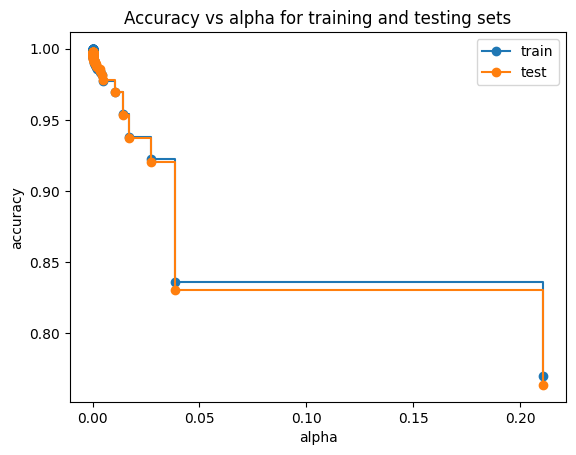

In [64]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",drawstyle="steps-post")
ax.legend()
plt.show()

Following the bias and variance tradeoff, we choose that have low bias (low training error), and low variance (low test error). That value is **alpha = 0**.

In [68]:
clf=DecisionTreeClassifier(random_state=0,ccp_alpha=0)
clf.fit(X_train,y_train)
accuracy_score(y_test,clf.predict(X_test))

0.9976795315742493

The original decision tree model and post-pruning model give the same accuracy. Interesting. The test accuracy is higher than SVM, and because Decision Tree doesn't seem to have GPU supported libraries, so I won't perfrom pre-pruning (it is just grid search), since it will take too long.

## KNN

In [23]:
# Grid search
knn = KNeighborsClassifier()
param_grid_knn = {
    'n_neighbors': list(range(1, 101)),
    'algorithm': ['brute','auto'],
}
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5)
grid_search_knn.fit(X_train, y_train)
best_params_knn = grid_search_knn.best_params_
print(f"Best hyperparameters for KNN: {best_params_knn}")

# Evaluate the best model on the test set
best_knn = grid_search_knn.best_estimator_
accuracy_knn = best_knn.score(X_test, y_test)

[I] [11:13:49.723711] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [11:13:49.730671] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [11:13:49.853715] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [11:13:49.947777] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [11:13:49.996617] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [11:13:50.050520] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [11:13:50.100091] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [11:13:50.151437] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [11:13:50.201885] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [11:13:50.255327] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [11:13:50.304156] Unused keyword parameter: n_jobs during cuML estimator ini

/home/tomadonna/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
500 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
500 fits failed with the following error:
Traceback (most recent call last):
  File "/home/tomadonna/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/tomadonna/.local/lib/python3.10/site-packages/cuml/internals/api_decorators.py", line 188, in wrapper
    ret = func(*args, **kwargs)
  File "kneighbors_classifier.pyx", line 166, in cuml.neighbors.kneighbors_classifier.KNeighborsClassifier.fit
  File "/home/tomadonna/.loca

In [26]:
best_params_knn

{'algorithm': 'auto', 'n_neighbors': 1}

In [27]:
print(f"Test set accuracy: {accuracy_knn}")

Test set accuracy: 0.996213972568512


I have used grid search to find the optimal hyperparameter for each SVM and KNN. I have used post prunning for fine tune Decision Tree. It seems like Decision Tree output the best score with 0.9977. The score could be a little bit higher if I had used grid search on Decision Tree, but it took so long so I just settled for this value.

# 5. Build 3 ensemble models

## Random Forest

In [23]:
rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],  # number of trees in the forest
    'split_criterion': [0, 1], #  criterion used to split nodes
    'max_depth': [10, 20, 30],  # maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # minimum number of samples required to be at a leaf node
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300],
                         'split_criterion': [0, 1]})

This took 2000 seconds to load.

In [25]:
grid_search.best_params_

{'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200,
 'split_criterion': 0}

I will run the grid search another time.

In [26]:
param_grid = {
    'n_estimators': [175, 200, 225],  # number of trees in the forest
    'split_criterion': [0], #  criterion used to split nodes
    'max_depth': [15, 20, 25],  # maximum depth of each tree
    'min_samples_split': [2],  # minimum number of samples required to split an internal node
    'min_samples_leaf': [1],  # minimum number of samples required to be at a leaf node
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [15, 20, 25], 'min_samples_leaf': [1],
                         'min_samples_split': [2],
                         'n_estimators': [175, 200, 225],
                         'split_criterion': [0]})

In [27]:
grid_search.best_params_

{'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200,
 'split_criterion': 0}

I think after 2 grid search we found the most optimal hyperparameter for random forest

In [28]:
y_pred = grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {test_accuracy:.4f}")

Test set accuracy: 0.9969


In [29]:
# classification report
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1566
           1       1.00      0.79      0.89       107
           2       1.00      1.00      1.00     18757
           3       1.00      1.00      1.00       861
           4       1.00      0.90      0.95        10
           5       0.82      1.00      0.90         9
           6       1.00      1.00      1.00       396
           7       1.00      1.00      1.00       207
           8       0.96      0.98      0.97       541
           9       1.00      1.00      1.00       415
          10       0.99      0.98      0.99      1649
          11       1.00      0.91      0.95        46

    accuracy                           1.00     24564
   macro avg       0.98      0.96      0.97     24564
weighted avg       1.00      1.00      1.00     24564



# Gradient Boost

In [69]:
lgb_gradient = LGBMClassifier()

param_grid = {
    'num_leaves': [31, 50, 100],           # Number of leaves in the tree
    'learning_rate': [0.01],    
    'n_estimators': [100, 200],       # Number of boosting iterations
    'min_child_samples': [20, 30],     # Minimum number of samples per leaf
    'subsample': [0.8],               # Fraction of data used for fitting each base learner
    'colsample_bytree': [0.8],        # Fraction of features used for fitting each tree
}

grid_search = GridSearchCV(estimator=lgb_gradient, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13358
[LightGBM] [Info] Number of data points in the train set: 78603, number of used features: 82
[LightGBM] [Info] Start training from score -2.769071
[LightGBM] [Info] Start training from score -5.440283
[LightGBM] [Info] Start training from score -0.261089
[LightGBM] [Info] Start training from score -3.401999
[LightGBM] [Info] Start training from score -8.181123
[LightGBM] [Info] Start training from score -8.564115
[LightGBM] [Info] Start training from score -4.119114
[LightGBM] [Info] Start training from score -4.818540
[LightGBM] [Info] Start training from score -3.872767
[LightGBM] [Info] Start training from score -4.123034
[LightGBM] [Info] Start training from score -2.725607
[LightGBM] [Info] Start training from score -6.16017

GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid={'colsample_bytree': [0.8], 'learning_rate': [0.01],
                         'min_child_samples': [20, 30],
                         'n_estimators': [100, 200],
                         'num_leaves': [31, 50, 100], 'subsample': [0.8]})

In [71]:
grid_search.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.01,
 'min_child_samples': 20,
 'n_estimators': 200,
 'num_leaves': 100,
 'subsample': 0.8}

In [73]:
y_pred = grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {test_accuracy:.4f}")

Test set accuracy: 0.9982


In [74]:
# classification report
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1566
           1       1.00      0.98      0.99       107
           2       1.00      1.00      1.00     18757
           3       1.00      1.00      1.00       861
           4       0.90      0.90      0.90        10
           5       1.00      1.00      1.00         9
           6       1.00      1.00      1.00       396
           7       1.00      1.00      1.00       207
           8       0.99      0.99      0.99       541
           9       1.00      1.00      1.00       415
          10       0.99      0.99      0.99      1649
          11       1.00      0.93      0.97        46

    accuracy                           1.00     24564
   macro avg       0.99      0.98      0.99     24564
weighted avg       1.00      1.00      1.00     24564



## Stacking classifier
I will first try stacking classifer on the 2 models that give the best performance which is Decision Tree and Graident Boost.

In [99]:
stacking_clf = StackingClassifier(
    estimators=[
        ('clf', DecisionTreeClassifier(random_state=0)), 
        ('lgbm', LGBMClassifier(colsample_bytree=0.8, learning_rate=0.01, min_child_samples=20, n_estimators=200, num_leaves=100, subsample=0.8))],
    final_estimator=LGBMClassifier(colsample_bytree=0.8, learning_rate=0.01, min_child_samples=20, n_estimators=200, num_leaves=100, subsample=0.8),
    cv=5,
)
stacking_clf.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13665
[LightGBM] [Info] Number of data points in the train set: 98254, number of used features: 82
[LightGBM] [Info] Start training from score -2.768992
[LightGBM] [Info] Start training from score -5.440872
[LightGBM] [Info] Start training from score -0.261082
[LightGBM] [Info] Start training from score -3.402155
[LightGBM] [Info] Start training from score -8.199474
[LightGBM] [Info] Start training from score -8.550872
[LightGBM] [Info] Start training from score -4.118803
[LightGBM] [Info] Start training from score -4.818228
[LightGBM] [Info] Start training from score -3.873137
[LightGBM] [Info] Start training from score -4.122565
[LightGBM] [Info] Start training from score -2.725649
[LightGBM] [Info] Start training from score -6.16259

StackingClassifier(cv=5,
                   estimators=[('clf', DecisionTreeClassifier(random_state=0)),
                               ('lgbm',
                                LGBMClassifier(colsample_bytree=0.8,
                                               learning_rate=0.01,
                                               n_estimators=200, num_leaves=100,
                                               subsample=0.8))],
                   final_estimator=LGBMClassifier(colsample_bytree=0.8,
                                                  learning_rate=0.01,
                                                  n_estimators=200,
                                                  num_leaves=100,
                                                  subsample=0.8))

In [100]:
for name, clf in stacking_clf.named_estimators_.items():
     print(name, "=", clf.score(X_test, y_test))

clf = 0.9976795310210064
lgbm = 0.9982087607881452


In [102]:
stacking_clf.score(X_test, y_test)

0.9983308907344081

I will perform the same thing but with Random Forest and Gradient Boost

In [103]:
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200, split_criterion=0)), 
        ('lgbm', LGBMClassifier(colsample_bytree=0.8, learning_rate=0.01, min_child_samples=20, n_estimators=200, num_leaves=100, subsample=0.8))],
    final_estimator=LGBMClassifier(colsample_bytree=0.8, learning_rate=0.01, min_child_samples=20, n_estimators=200, num_leaves=100, subsample=0.8),
    cv=5,
)
stacking_clf.fit(X_train, y_train)
stacking_clf.score(X_test, y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13665
[LightGBM] [Info] Number of data points in the train set: 98254, number of used features: 82
[LightGBM] [Info] Start training from score -2.768992
[LightGBM] [Info] Start training from score -5.440872
[LightGBM] [Info] Start training from score -0.261082
[LightGBM] [Info] Start training from score -3.402155
[LightGBM] [Info] Start training from score -8.199474
[LightGBM] [Info] Start training from score -8.550872
[LightGBM] [Info] Start training from score -4.118803
[LightGBM] [Info] Start training from score -4.818228
[LightGBM] [Info] Start training from score -3.873137
[LightGBM] [Info] Start training from score -4.122565
[LightGBM] [Info] Start training from score -2.725649
[LightGBM] [Info] Start training from score -6.16259

0.9982494707702328

Here is an example on using stacking classifier with KNN and Gradient Boost

In [38]:
stacking_clf = StackingClassifier(
    estimators=[
        ('knn', KNeighborsClassifier(algorithm = 'auto', n_neighbors = 1)), 
        ('lgbm', LGBMClassifier(colsample_bytree=0.8, learning_rate=0.01, min_child_samples=20, n_estimators=200, num_leaves=100, subsample=0.8))],
    final_estimator=LGBMClassifier(colsample_bytree=0.8, learning_rate=0.01, min_child_samples=20, n_estimators=200, num_leaves=100, subsample=0.8),
    cv=5,
)
stacking_clf.fit(X_train, y_train)
stacking_clf.score(X_test, y_test)

[I] [06:12:16.517467] Unused keyword parameter: n_jobs during cuML estimator initialization
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13665
[LightGBM] [Info] Number of data points in the train set: 98254, number of used features: 82
[LightGBM] [Info] Start training from score -2.768992
[LightGBM] [Info] Start training from score -5.440872
[LightGBM] [Info] Start training from score -0.261082
[LightGBM] [Info] Start training from score -3.402155
[LightGBM] [Info] Start training from score -8.199474
[LightGBM] [Info] Start training from score -8.550872
[LightGBM] [Info] Start training from score -4.118803
[LightGBM] [Info] Start training from score -4.818228
[LightGBM] [Info] Start training from score -3.873137
[LightGBM] [Info] Start training from score -4.122565
[LightGBM] [In

0.9980052108777072